Installing Yahoo Finance to access stack data

In [ ]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 2.9 MB/s 
     |████████████████████████████████| 112 kB 9.7 MB/s 
     |████████████████████████████████| 110 kB 52.9 MB/s 
     |████████████████████████████████| 128 kB 57.2 MB/s 
     |████████████████████████████████| 4.0 MB 45.7 MB/s 
     |████████████████████████████████| 62 kB 1.6 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


# Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from math import floor

#Setting default styles
plt.rcParams['figure.figsize'] = (20,10)
plt.style.use('fivethirtyeight')

# Downloading and Storing stock data of **GOOGLE**

In [ ]:
symbol='GOOGL'
start='2016-01-01'
end='2021-01-01'
df=yf.download(symbol,start,end)


[*********************100%***********************]  1 of 1 completed


# Dopping columns and rows with NaN values

In [ ]:
df=df.dropna()

# Displaying stock prices 

In [ ]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-04,38.110001,38.110001,37.376999,37.972000,37.972000,67382000
2016-01-05,38.205002,38.459999,37.782501,38.076500,38.076500,45216000
2016-01-06,37.518501,38.286499,37.400002,37.966499,37.966499,48206000
2016-01-07,37.324501,37.765499,36.764000,37.049999,37.049999,63132000
2016-01-08,37.389999,37.506001,36.445999,36.545502,36.545502,47506000


# 1. **Williams%R Indicator**

Founded by Larry Williams, the Williams %R is a momentum indicator whose values oscillate between **0 to -100**. Traders use this indicator to spot potential entry and exit points for trades by constructing two levels of overbought and oversold. 

**Formula**- 
## _`W%R_14 = [ H.HIGH - C.PRICE ] / [ L.LOW - C.PRICE ] * ( - 100 )`_

where,

W%R 14 = 14-day Williams %R of the stock

H.HIGH = 14-day Highest High of the stock

L.LOW = 14-day Lowest Low of the stock

C.PRICE = Closing price of the stock

To read more about this indicator- [Williams%R](https://www.investopedia.com/terms/w/williamsr.asp)



In [ ]:
def williamsR(high, low, close, time):

  highesth=high.rolling(time).max()
  lowestl=low.rolling(time).min()

  williams=((highesth-close)/(highesth-lowestl))*(-100)

  return williams
 
#adding wr column using the above function
df['wr'] = williamsR(df['High'], df['Low'], df['Close'], 14)

df=df.dropna()

df


,Open,High,Low,Close,Adj Close,Volume,wr
Date,,,,,,,
2016-01-22,37.099998,37.428001,37.025002,37.272999,37.272999,47146000,-29.157468
2016-01-25,37.192001,37.623001,36.625000,36.681000,36.681000,45340000,-43.699329
2016-01-26,36.760502,36.973000,36.348499,36.689499,36.689499,30940000,-40.974997
2016-01-27,36.794498,36.794498,35.672501,35.879002,35.879002,42428000,-55.871404
2016-01-28,36.909500,37.557999,36.529999,37.415001,37.415001,62104000,-7.206394
...,...,...,...,...,...,...,...
2020-12-24,86.449997,87.120499,86.217499,86.708000,86.708000,9312000,-70.315586
2020-12-28,87.245499,89.349998,87.091003,88.697998,88.697998,27650000,-40.492705
2020-12-29,89.361504,89.423500,87.755501,87.888000,87.888000,19726000,-52.548921


# Plotting **Closing price** and **Williams%R** for the given stock

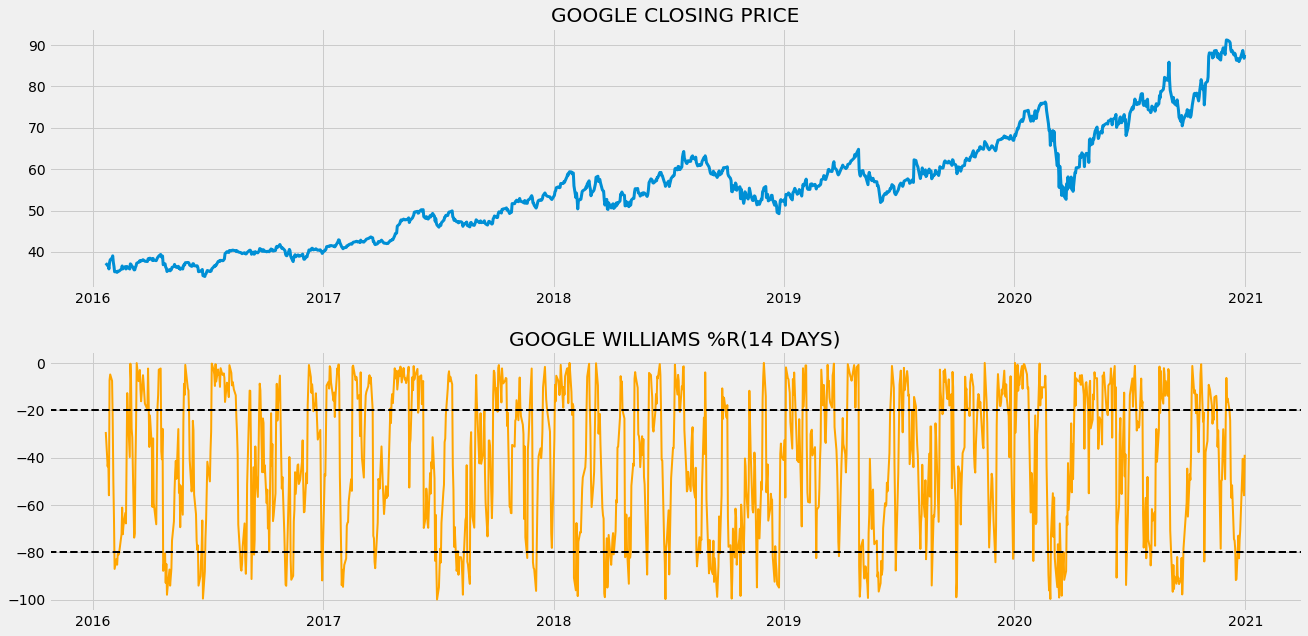

In [ ]:
graph1 = plt.subplot2grid((11,1), (0,0), rowspan = 5, colspan = 2)
graph2 = plt.subplot2grid((11,1), (6,0), rowspan = 6, colspan = 2)

graph1.plot(df['Close'], linewidth = 3)
graph1.set_title('GOOGLE CLOSING PRICE')

graph2.plot(df['wr'], color = 'orange', linewidth = 2)
graph2.axhline(-20, linewidth = 2, linestyle = '--', color = 'black')
graph2.axhline(-80, linewidth = 2, linestyle = '--', color = 'black')
graph2.set_title('GOOGLE WILLIAMS %R(14 DAYS)')

plt.show()

# **Trading strategy for William %R**

Now, We define a function following the below strategy:


*   When the prior reading of the Williams%R is < -20 and the current reading is > -20, the strategy generates a buy signal
*   A sell signal is issued when the prior value of the Williams%R is > -80 and the current reading is < -80.




In [ ]:
def strategy_implementation(close_prices,WR):

  #Creating theree empty lists
  buying_price=[]
  selling_price=[]
  wr_signal=[]
  position=0

  #if position=1, buy the stock
  #if position=-1, sell the stock

  for day in range(len(WR)):

    if WR[day-1] < -20 and WR[day] > -20: 

            if position != -1:

                buying_price.append(np.nan)
                selling_price.append(close_prices[day])
                position = -1
                wr_signal.append(position)

            else:

              buying_price.append(np.nan)
              selling_price.append(np.nan)
              wr_signal.append(0)
    
    elif WR[day-1] > -80 and WR[day] < -80:

            if position != 1:

                buying_price.append(close_prices[day])
                selling_price.append(np.nan)
                position = 1
                wr_signal.append(position)

            else:

                buying_price.append(np.nan)
                selling_price.append(np.nan)
                wr_signal.append(0)
    
    else:
            buying_price.append(np.nan)
            selling_price.append(np.nan)
            wr_signal.append(0)

  return buying_price, selling_price, wr_signal

#Storing the output for the given stock
buying_price, selling_price, wr_signal = strategy_implementation(df['Close'], df['wr'])
            
               
    

# **Creating trade position**

In [ ]:
#creating an empty list that will indicate 1, if we hold the stock and 0, if we don't own or hold the stock
trade_position=[]

#generating values to match the length of the 'position' list
for i in range(len(wr_signal)):

  trade_position.append(0)

#iterating over the values of the ‘position’ list, and the values of the ‘trade_position’ list get appended concerning which condition gets satisfied
for i in range(len(df['Close'])):

    if wr_signal[i] == 1:

        trade_position[i] = 1

    elif wr_signal[i] == -1:

        trade_position[i] = 0

    else:

        trade_position[i] = trade_position[i-1]

#Adding 'wr_signal' and 'wr_position' to df
wr_signal = pd.DataFrame(wr_signal).rename(columns = {0:'wr_signal'}).set_index(df.index)
position = pd.DataFrame(trade_position).rename(columns = {0:'wr_position'}).set_index(df.index)

frames = [df["Close"], df["wr"], wr_signal, position]

#Making a table that dispays the above frames
strategy = pd.concat(frames, join = 'inner', axis = 1)

strategy.head()




,Close,wr,wr_signal,wr_position
Date,,,,
2016-01-22,37.272999,-29.157468,0,0
2016-01-25,36.681000,-43.699329,0,0
2016-01-26,36.689499,-40.974997,0,0
2016-01-27,35.879002,-55.871404,0,0
2016-01-28,37.415001,-7.206394,-1,0


# **Backtesting**

We will now backtest our strategy by investing **10000 USD** in the given stock. The output will be the returns with respect to our strategy in USD and percentage returns.

In [ ]:
#Creating an empty list for returns per stock
wr_returns=[]

#Calculating the returns per stock using diff function and storing it in a dataframe
returns=pd.DataFrame(np.diff(df["Close"])).rename(columns={0:'returns'})

#Appending returns to wr_returns according to the trading strategy
for i in range(len(returns)):

  r=returns['returns'][i]*strategy['wr_position'][i]
  wr_returns.append(r)

#Converting wr_returns list to a dataframe
wr_returns_df = pd.DataFrame(wr_returns).rename(columns = {0:'wr_returns'})

investment_value = 10000

number_of_stocks = floor(investment_value/df['Close'][-1])

wr_investment_returns = []

#Finding returns for the total investment
for i in range(len(wr_returns_df['wr_returns'])):

    r = number_of_stocks*wr_returns_df['wr_returns'][i]
    wr_investment_returns.append(r)

#Converting investment_returns to a dataframe
wr_investment_returns_df = pd.DataFrame(wr_investment_returns).rename(columns = {0:'investment_returns'})

#Adding all investment returns to get total returns
total_returns=round(sum(wr_investment_returns_df['investment_returns']),3)

#Taking out percentage returns
percentage_return= 100*(total_returns/investment_value)

#Printing the returns
print("Profit gained in dollars: "+ str(total_returns)  )
print("%age returns: " + str(percentage_return))




Profit gained in dollars: 5459.119
%age returns: 54.59119


#### **Profit Gained:** $5459.119 <br>
#### **Returns:** 54.59119%

<br>

---







# 2. Average True Range (ATR)

The average true range (ATR) is a market volatility indicator used in technical analysis. It is typically derived from the 14-day simple moving average of a series of true range indicators. ATR shows investors the average range prices swing for an investment over a specified period.

The formula for ATR is:

#           _`[Previous ATR (n - 1) + TR ] / n`_




n= number of periods

TR= the true range


If there is not a previous ATR calculated, you must use:


( 1 / n ) Σni TRi

Where:

TRi = a particular true range, such as the first day's TR, then the second, then third
n = the number of periods

## _`TR = Max [ ( H − L ), Abs ( H − CP ), Abs ( L − CP ) ]`_

H = Today's high

L = Today's low

Cp = Yesterday's closing price

Max = The highest value of the three terms




Downloading and Storing stock data of **GOOGLE**

In [ ]:
symbol='GOOGL'
start='2016-01-01'
end='2021-01-01'
data=yf.download(symbol,start,end)
data.dropna()
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-04,38.110001,38.110001,37.376999,37.972000,37.972000,67382000
2016-01-05,38.205002,38.459999,37.782501,38.076500,38.076500,45216000
2016-01-06,37.518501,38.286499,37.400002,37.966499,37.966499,48206000
2016-01-07,37.324501,37.765499,36.764000,37.049999,37.049999,63132000
2016-01-08,37.389999,37.506001,36.445999,36.545502,36.545502,47506000


# Defining ATR:

In [ ]:

high_low = data['High'] - data['Low']
high_cp = np.abs(data['High'] - data['Close'].shift())
low_cp = np.abs(data['Low'] - data['Close'].shift())
df = pd.concat([high_low, high_cp, low_cp], axis=1)
true_range = np.max(df, axis=1)
average_true_range = true_range.rolling(14).mean()

    

# Adding ATR column to the data:

In [ ]:
data['ATR'] = average_true_range
data.dropna()
data

,Open,High,Low,Close,Adj Close,Volume,ATR
Date,,,,,,,
2016-01-04,38.110001,38.110001,37.376999,37.972000,37.972000,67382000,NaN
2016-01-05,38.205002,38.459999,37.782501,38.076500,38.076500,45216000,NaN
2016-01-06,37.518501,38.286499,37.400002,37.966499,37.966499,48206000,NaN
2016-01-07,37.324501,37.765499,36.764000,37.049999,37.049999,63132000,NaN
2016-01-08,37.389999,37.506001,36.445999,36.545502,36.545502,47506000,NaN
...,...,...,...,...,...,...,...
2020-12-24,86.449997,87.120499,86.217499,86.708000,86.708000,9312000,1.617749
2020-12-28,87.245499,89.349998,87.091003,88.697998,88.697998,27650000,1.712713
2020-12-29,89.361504,89.423500,87.755501,87.888000,87.888000,19726000,1.739892


# Plotting Close price and ATR:

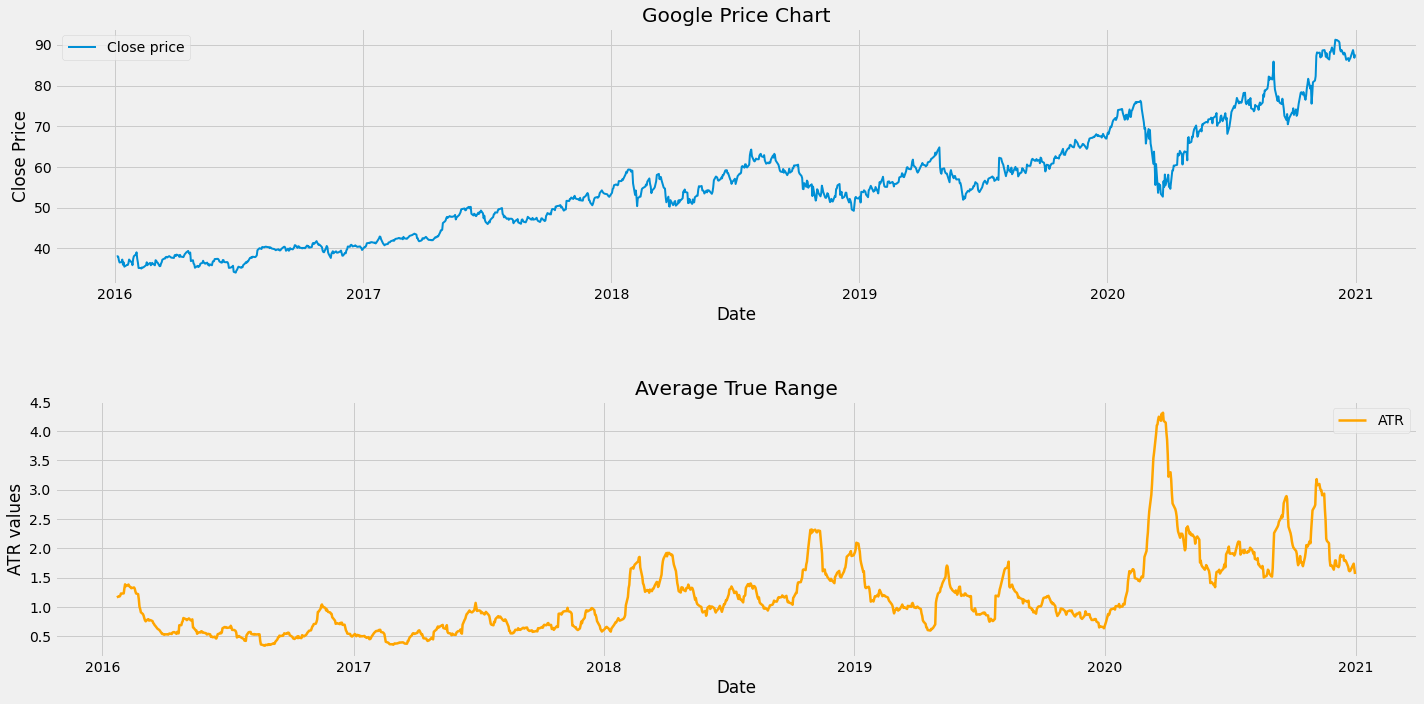

In [ ]:


# Define position of 1st subplot
ax = plt.subplot2grid((11,1), (0,0), rowspan = 5, colspan = 2)

# Set the title and axis labels
plt.title('Google Price Chart')
plt.xlabel('Date')
plt.ylabel('Close Price')

plt.plot(data['Close'], label='Close price', linewidth=2)

# Add a legend to the axis
plt.legend()

# Define position of 2nd subplot
bx= plt.subplot2grid((11,1), (6,0), rowspan = 5, colspan = 2)

# Set the title and axis labels
plt.title('Average True Range')
plt.xlabel('Date')
plt.ylabel('ATR values')

plt.plot(data['ATR'] , 'm', label='ATR',color='orange',linewidth=2.5)

# Add a legend to the axis
plt.legend()

plt.tight_layout()
plt.show()

# Trading strategy using ATR:
We define a function following the strategy:


*   If sum of present ATR and yesterday's close price is greater than today's close price, we **buy** the stock
*   If sum of present ATR and yesterday's close price is less than today's close price, we **sell** the stock.




In [ ]:
def strategy_ATR(close,atr):
  buying_price=[]
  selling_price=[]
  atr_signal=[]
  position=0

  for day in range(len(close)):

    if atr[day] + close[day-1]> close[day]:
      if position != 1:

                buying_price.append(close[day])
                selling_price.append(np.nan)
                position = 1
                atr_signal.append(position)
      else:
        
                buying_price.append(np.nan)
                selling_price.append(np.nan)
                atr_signal.append(0)
      
    elif atr[day] + close[day-1]< close[day]:

      if position != -1:

        buying_price.append(np.nan)
        selling_price.append(close[day])
        position = -1
        atr_signal.append(position)

      else:

        buying_price.append(np.nan)
        selling_price.append(np.nan)
        atr_signal.append(0)
   
    else:

      buying_price.append(np.nan)
      selling_price.append(np.nan)
      atr_signal.append(0)
  
  return buying_price, selling_price, atr_signal

buying_price,sellin_price, atr_signal= strategy_ATR(data['Close'], data['ATR'])


# Creating a list for trade position:

In [ ]:
#creating an empty list that will indicate 1, if we hold the stock and 0, if we don't own or hold the stock
trade_position=[]

#generating values to match the length of the 'position' list
for i in range(len(atr_signal)):

  trade_position.append(0)

#iterating over the values of the ‘position’ list, and the values of the ‘trade_position’ list get appended concerning which condition gets satisfied
for i in range(len(data['Close'])):

  if atr_signal[i] == 1:

      trade_position[i] = 1

  elif atr_signal[i] == -1:

      trade_position[i] = 0

  else:

      trade_position[i] = trade_position[i-1]

#Adding 'wr_signal' and 'wr_position' to df
atr_signal = pd.DataFrame(atr_signal).rename(columns = {0:'atr_signal'}).set_index(data.index)
position = pd.DataFrame(trade_position).rename(columns = {0:'atr_position'}).set_index(data.index)

frames = [data["Close"], data["ATR"], atr_signal, position]

#Making a table that dispays the above frames
strategy = pd.concat(frames, join = 'inner', axis = 1)
strategy.dropna(axis=0)
strategy.head()

,Close,ATR,atr_signal,atr_position
Date,,,,
2016-01-04,37.972000,NaN,0,0
2016-01-05,38.076500,NaN,0,0
2016-01-06,37.966499,NaN,0,0
2016-01-07,37.049999,NaN,0,0
2016-01-08,36.545502,NaN,0,0


# Backtesting

We will now backtest our strategy by investing **10000 USD** in the given stock. The output will be the returns with respect to our strategy in USD and percentage returns.

In [ ]:
#Creating an empty list for returns per stock
atr_returns=[]

#Calculating the returns per stock using diff function and storing it in a dataframe
returns=pd.DataFrame(np.diff(data["Close"])).rename(columns={0:'returns'})

#Appending returns to atr_returns according to the trading strategy
for i in range(len(returns)):

  r=returns['returns'][i]*strategy['atr_position'][i]
  atr_returns.append(r)

#Converting atr_returns list to a dataframe
atr_returns_df = pd.DataFrame(atr_returns).rename(columns = {0:'atr_returns'})

investment_value = 10000

number_of_stocks = floor(investment_value/data['Close'][-1])

atr_investment_returns = []

#Finding returns for the total investment
for i in range(len(atr_returns_df['atr_returns'])):

    r = number_of_stocks*atr_returns_df['atr_returns'][i]
    atr_investment_returns.append(r)

#Converting investment_returns to a dataframe
atr_investment_returns_df = pd.DataFrame(atr_investment_returns).rename(columns = {0:'investment_returns'})

#Adding all investment returns to get total returns
total_returns=round(sum(atr_investment_returns_df['investment_returns']),3)

#Taking out percentage returns
percentage_return= 100*(total_returns/investment_value)

#Printing the returns
print("Profit gained in dollars: "+ str(total_returns)  )
print("%age returns: " + str(percentage_return))



Profit gained in dollars: 7092.965
%age returns: 70.92965


#### **Profit Gained:** $7092.965 <br>
#### **Returns:** 70.92965%

<br>

---


# 3. Money Flow Index

The **Money Flow Index (MFI)** is a momentum indicator that measures the flow of money into and out of a security over a specified period of time. The MFI is calculated by accumulating positive and negative Money Flow values (see Money Flow), then creating a **Money Ratio**. The Money Ratio is then normalized into the MFI oscillator form.

Calculation:

## *Typical Price = (High + Low + Close)/3*

# _`Money Flow = Typical Price * Volume`_



*   If today's Typical Price is greater than yesterday's Typical Price,it is considered Positive Money Flow.
*   If today's price is less, it is considered Negative Money Flow.

<br>


Money Flow Ratio= 
14-Period Negative Money Flow/
14-Period Positive Money Flow
​

# _``Money Flow Index=100−100/(1+Money Flow Ratio)``_

​


# Downloading and storing stock data

In [ ]:
symbol='GOOGL'
start='2016-01-01'
end='2021-01-01'
data=yf.download(symbol,start,end)
data.dropna()
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-04,38.110001,38.110001,37.376999,37.972000,37.972000,67382000
2016-01-05,38.205002,38.459999,37.782501,38.076500,38.076500,45216000
2016-01-06,37.518501,38.286499,37.400002,37.966499,37.966499,48206000
2016-01-07,37.324501,37.765499,36.764000,37.049999,37.049999,63132000
2016-01-08,37.389999,37.506001,36.445999,36.545502,36.545502,47506000


# Defining gain and loss function:

In [ ]:
def gain(x):
    return ((x > 0) * x).sum()


def loss(x):
    return ((x < 0) * x).sum()

# Defining MFI function from the above mentioned formula:

In [ ]:
def mfi(high, low, close, volume, n=14):
  
    typical_price = (high + low + close)/3
    money_flow = typical_price * volume
    mf_sign = np.where(typical_price > typical_price.shift(1), 1, -1)
    signed_mf = money_flow * mf_sign
    mf_avg_gain = signed_mf.rolling(n).apply(gain, raw=True)
    mf_avg_loss = signed_mf.rolling(n).apply(loss, raw=True)
    return (100 - (100 / (1 + (mf_avg_gain / abs(mf_avg_loss))))).to_numpy()

# Adding MFI column to data

In [ ]:
data['MFI'] = mfi(data['High'], data['Low'], data['Close'], data['Volume'], 14)
data.dropna()
data


,Open,High,Low,Close,Adj Close,Volume,MFI
Date,,,,,,,
2016-01-04,38.110001,38.110001,37.376999,37.972000,37.972000,67382000,NaN
2016-01-05,38.205002,38.459999,37.782501,38.076500,38.076500,45216000,NaN
2016-01-06,37.518501,38.286499,37.400002,37.966499,37.966499,48206000,NaN
2016-01-07,37.324501,37.765499,36.764000,37.049999,37.049999,63132000,NaN
2016-01-08,37.389999,37.506001,36.445999,36.545502,36.545502,47506000,NaN
...,...,...,...,...,...,...,...
2020-12-24,86.449997,87.120499,86.217499,86.708000,86.708000,9312000,18.530900
2020-12-28,87.245499,89.349998,87.091003,88.697998,88.697998,27650000,25.084427
2020-12-29,89.361504,89.423500,87.755501,87.888000,87.888000,19726000,25.124449


# Plotting close price and MFI:

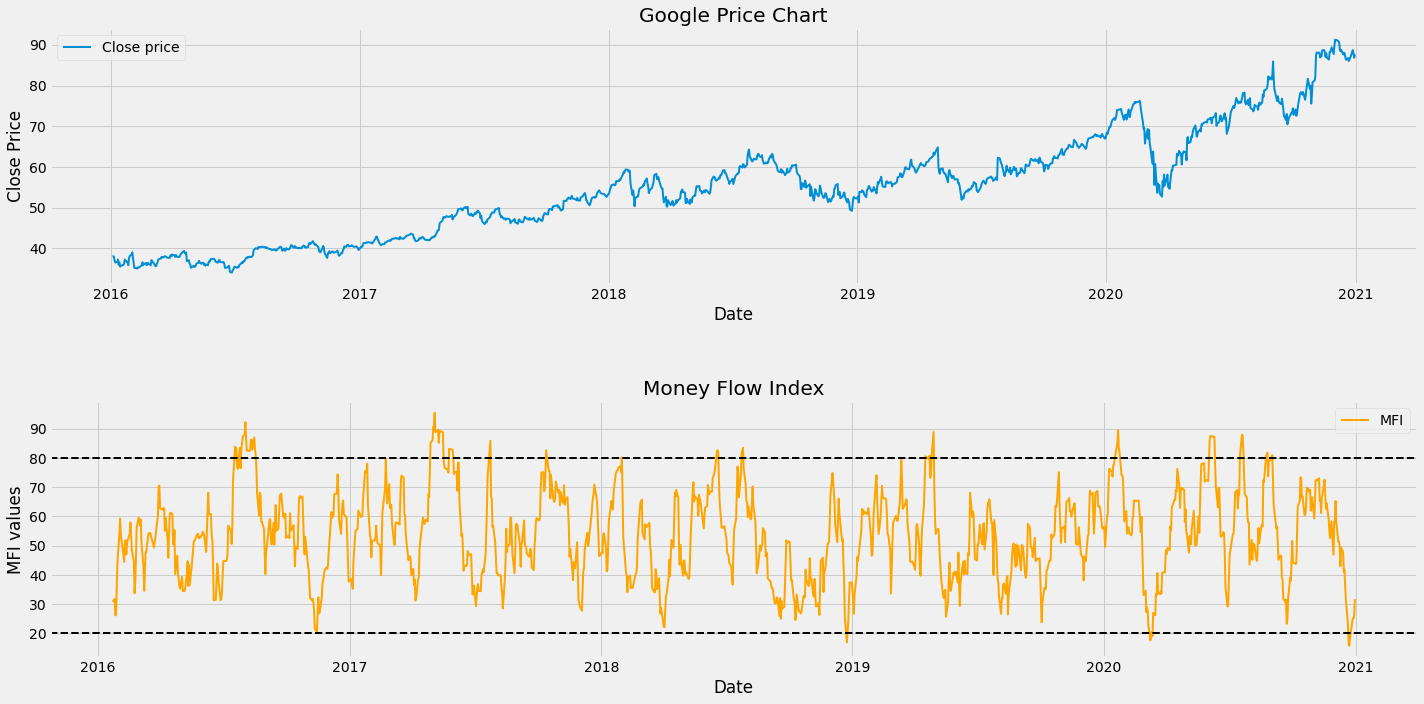

In [ ]:
# Define position of 1st subplot
fig1=plt.subplot2grid((11,1), (0,0), rowspan = 5, colspan = 2)

# Set the title and axis labels
plt.title('Google Price Chart')
plt.xlabel('Date')
plt.ylabel('Close Price')

plt.plot(data['Close'], label='Close price', linewidth=2)

# Add a legend to the axis
plt.legend()

# Define position of 2nd subplot
bx= plt.subplot2grid((11,1), (6,0), rowspan = 5, colspan = 2)

# Set the title and axis labels
plt.title('Money Flow Index')
plt.xlabel('Date')
plt.ylabel('MFI values')


plt.plot(data['MFI'], 'm', label='MFI',linewidth=2, color='orange')
bx.axhline(20, linewidth = 2, linestyle = '--', color = 'black')
bx.axhline(80, linewidth = 2, linestyle = '--', color = 'black')

# Add a legend to the axis
plt.legend()

plt.tight_layout()
plt.show()


# Trading strategy using MFI:
We define a function following the below strategy:

*   If the MFI value crosses above 80, the stock is said to be in the overbought region and thus should be sold.
*   If the MFI value crosses below 20, the stock is said to be in the oversold region and thus should be bought. 


 

In [ ]:
def strategy_mfi(close, mfi):
  buy_price = []
  sell_price = []
  mfi_signal = []
  position = 0
  for i in range(len(mfi)):
    if mfi[i] > 80:
      if position != -1:
       buy_price.append(np.nan)
       sell_price.append(close[i])
       position = -1
       mfi_signal.append(position)

      else:

        buy_price.append(np.nan)
        sell_price.append(np.nan)
        mfi_signal.append(0)
    elif mfi[i] < 20:
       if position != 1:

                buy_price.append(close[i])
                sell_price.append(np.nan)
                position = 1
                mfi_signal.append(position)
       else:
        
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                mfi_signal.append(0)
    else:
      buy_price.append(np.nan)
      sell_price.append(np.nan)
      mfi_signal.append(0)
  return buy_price, sell_price, mfi_signal

buy_price,sell_price, mfi_signal= strategy_mfi(data['Close'], data['MFI'])


# Creating a list for trade position

In [ ]:
#creating an empty list that will indicate 1, if we hold the stock and 0, if we don't own or hold the stock
trade_position=[]

#generating values to match the length of the 'position' list
for i in range(len(mfi_signal)):

  trade_position.append(0)

#iterating over the values of the ‘position’ list, and the values of the ‘trade_position’ list get appended concerning which condition gets satisfied
for i in range(len(data['Close'])):

  if mfi_signal[i] == 1:

      trade_position[i] = 1

  elif mfi_signal[i] == -1:

      trade_position[i] = 0

  else:

      trade_position[i] = trade_position[i-1]

#Adding 'mfi_signal' and 'mfi_position' to df
mfi_signal = pd.DataFrame(mfi_signal).rename(columns = {0:'mfi_signal'}).set_index(data.index)
position = pd.DataFrame(trade_position).rename(columns = {0:'mfi_position'}).set_index(data.index)

frames = [data["Close"], data["MFI"], mfi_signal, position]

#Making a table that dispays the above frames
strategy = pd.concat(frames, join = 'inner', axis = 1)
strategy.dropna()
strategy.head()

,Close,MFI,mfi_signal,mfi_position
Date,,,,
2016-01-04,37.972000,NaN,0,0
2016-01-05,38.076500,NaN,0,0
2016-01-06,37.966499,NaN,0,0
2016-01-07,37.049999,NaN,0,0
2016-01-08,36.545502,NaN,0,0


# Backtesting 

We will now backtest our strategy by investing **10000 USD** in the given stock. The output will be the returns with respect to our strategy in USD and percentage returns.

In [ ]:
#Creating an empty list for returns per stock
mfi_returns=[]

#Calculating the returns per stock using diff function and storing it in a dataframe
returns=pd.DataFrame(np.diff(data["Close"])).rename(columns={0:'returns'})

#Appending returns to mfi_returns according to the trading strategy
for i in range(len(returns)):

  r=returns['returns'][i]*strategy['mfi_position'][i]
  mfi_returns.append(r)

#Converting mfi_returns list to a dataframe
mfi_returns_df = pd.DataFrame(mfi_returns).rename(columns = {0:'mfi_returns'})

investment_value = 10000

number_of_stocks = floor(investment_value/data['Close'][-1])

mfi_investment_returns = []

#Finding returns for the total investment
for i in range(len(mfi_returns_df['mfi_returns'])):

    r = number_of_stocks*mfi_returns_df['mfi_returns'][i]
    mfi_investment_returns.append(r)

#Converting investment_returns to a dataframe
mfi_investment_returns_df = pd.DataFrame(mfi_investment_returns).rename(columns = {0:'investment_returns'})

#Adding all investment returns to get total returns
total_returns=round(sum(mfi_investment_returns_df['investment_returns']),3)

#Taking out percentage returns
percentage_return= 100*(total_returns/investment_value)

#Printing the returns
print("Profit gained in dollars: "+ str(total_returns)  )
print("%age returns: " + str(percentage_return))

Profit gained in dollars: 2914.695
%age returns: 29.14695


#### **Profit Gained:** $2914.695 <br>
#### **Returns:** 29.14695%

<br>

---


# 4. Elder force index
The Elder Force Index indicator is used to measure the power driving a movement in the price. It tries to highlight potential price reversals and corrections by analyzing the direction, length, and volume driving the price movement.

It is calculated by subtracting yesterday's close from today's close (net change) and multiplying the result by today's volume. 

# _``EFI = (Curr.Close - Prev.Close)*(Curr.Volume)``_

Where, <br>
Curr.Close = Current period Closing Price <br>
Prev.Close = Previous Period Closing Price <br>
Curr.Volume = Current Period Volume




# Downloading and storing stock data:

In [ ]:
symbol='GOOGL'
start='2016-01-01'
end='2021-01-01'
data=yf.download(symbol,start,end)
data.dropna()
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-04,38.110001,38.110001,37.376999,37.972000,37.972000,67382000
2016-01-05,38.205002,38.459999,37.782501,38.076500,38.076500,45216000
2016-01-06,37.518501,38.286499,37.400002,37.966499,37.966499,48206000
2016-01-07,37.324501,37.765499,36.764000,37.049999,37.049999,63132000
2016-01-08,37.389999,37.506001,36.445999,36.545502,36.545502,47506000


# Defining **Force Index function** to calculate the Force Index:

In [ ]:
def ForceIndex(data, ndays): 
    FI = pd.Series(data['Close'].diff(ndays) * data['Volume'], name = 'ForceIndex') 
    data = data.join(FI) 
    return data

# Computing Force Index
Using the function defined above, we compute the Force Index for GOOGLE. <br>
Note that:


*   If closing prices are higher today than yesterday, the force index is positive.
*   If closing prices are lower than yesterday's, the force index is negative.
 


In [ ]:
# Compute the Force Index for GOOGL
n = 1
AAPL_ForceIndex = ForceIndex(data,n)
data['ForceIndex']=AAPL_ForceIndex['ForceIndex']
data.dropna()
data

,Open,High,Low,Close,Adj Close,Volume,ForceIndex
Date,,,,,,,
2016-01-04,38.110001,38.110001,37.376999,37.972000,37.972000,67382000,NaN
2016-01-05,38.205002,38.459999,37.782501,38.076500,38.076500,45216000,4.725064e+06
2016-01-06,37.518501,38.286499,37.400002,37.966499,37.966499,48206000,-5.302689e+06
2016-01-07,37.324501,37.765499,36.764000,37.049999,37.049999,63132000,-5.786048e+07
2016-01-08,37.389999,37.506001,36.445999,36.545502,36.545502,47506000,-2.396666e+07
...,...,...,...,...,...,...,...
2020-12-24,86.449997,87.120499,86.217499,86.708000,86.708000,9312000,2.761019e+06
2020-12-28,87.245499,89.349998,87.091003,88.697998,88.697998,27650000,5.502344e+07
2020-12-29,89.361504,89.423500,87.755501,87.888000,87.888000,19726000,-1.597801e+07


# Plotting Close Price and Elder Force Index:

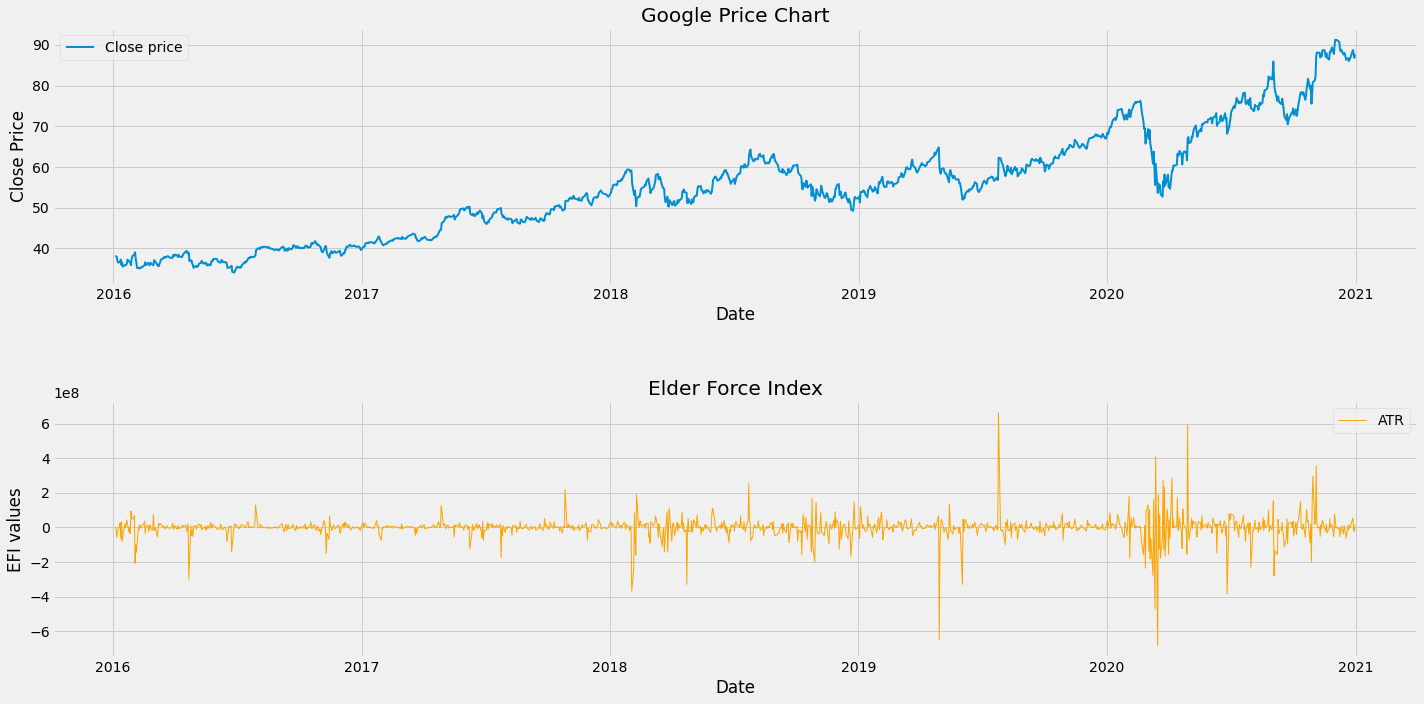

In [ ]:
# Define position of 1st subplot
ax = plt.subplot2grid((11,1), (0,0), rowspan = 5, colspan = 2)

# Set the title and axis labels
plt.title('Google Price Chart')
plt.xlabel('Date')
plt.ylabel('Close Price')

plt.plot(data['Close'], label='Close price', linewidth=2)

# Add a legend to the axis
plt.legend()

# Define position of 2nd subplot
bx= plt.subplot2grid((11,1), (6,0), rowspan = 5, colspan = 2)

# Set the title and axis labels
plt.title('Elder Force Index')
plt.xlabel('Date')
plt.ylabel('EFI values')

plt.plot(data['ForceIndex'] , 'm', label='ATR',color='orange',linewidth=1)

# Add a legend to the axis
plt.legend()

plt.tight_layout()
plt.show()

# Trading Strategy for Elder Force Index:<br>
We begin with computing 13-day EMA of the Force Index. 

# _``EMA = (Force Index) x multiplier + EMA (previous day) x (1-multiplier)``_

Where, <br>
Multiplier = 2/(No. of days +1)

Hence Defining a function to compute the EMA of Force Index:

In [ ]:
def EWMA(data, ndays): 
    EMA = pd.Series(data['ForceIndex'].ewm(span = ndays, min_periods = ndays - 1).mean(), 
                 name = 'EWMA_' + str(ndays)) 
    data = data.join(EMA) 
    return data
  
data=EWMA(data, 13)
data

,Open,High,Low,Close,Adj Close,Volume,ForceIndex,EWMA_13
Date,,,,,,,,
2016-01-04,38.110001,38.110001,37.376999,37.972000,37.972000,67382000,NaN,NaN
2016-01-05,38.205002,38.459999,37.782501,38.076500,38.076500,45216000,4.725064e+06,NaN
2016-01-06,37.518501,38.286499,37.400002,37.966499,37.966499,48206000,-5.302689e+06,NaN
2016-01-07,37.324501,37.765499,36.764000,37.049999,37.049999,63132000,-5.786048e+07,NaN
2016-01-08,37.389999,37.506001,36.445999,36.545502,36.545502,47506000,-2.396666e+07,NaN
...,...,...,...,...,...,...,...,...
2020-12-24,86.449997,87.120499,86.217499,86.708000,86.708000,9312000,2.761019e+06,-7.107248e+06
2020-12-28,87.245499,89.349998,87.091003,88.697998,88.697998,27650000,5.502344e+07,1.768565e+06
2020-12-29,89.361504,89.423500,87.755501,87.888000,87.888000,19726000,-1.597801e+07,-7.666605e+05


Now, We define a function following the below strategy:


*   When the 13-Day EMA of Force Index < 0, We sell the stock.
*   When the 13-Day EMA of Force Index > 0, We buy the stock.



In [ ]:
def strategy_efi(close, efi, EWMA_13):

  #Creating theree empty lists
  buying_price=[]
  selling_price=[]
  efi_signal=[]
  position=0

  #if position=1, buy the stock
  #if position=-1, sell the stock

  for day in range(len(efi)):
    
    if EWMA_13[day] <0:

            if position != -1:

                buying_price.append(np.nan)
                selling_price.append(close[day])
                position = -1
                efi_signal.append(position)

            else:

              buying_price.append(np.nan)
              selling_price.append(np.nan)
              efi_signal.append(0)
    
    elif EWMA_13[day] >0:

            if position != 1:

                buying_price.append(close[day])
                selling_price.append(np.nan)
                position = 1
                efi_signal.append(position)

            else:

                buying_price.append(np.nan)
                selling_price.append(np.nan)
                efi_signal.append(0)
    
    else:
            buying_price.append(np.nan)
            selling_price.append(np.nan)
            efi_signal.append(0)

  return buying_price, selling_price, efi_signal

buying_price, selling_price, efi_signal =strategy_efi(data['Close'], data['ForceIndex'], data['EWMA_13'])






# Creating a list for trade position:

In [ ]:
#creating an empty list that will indicate 1, if we hold the stock and 0, if we don't own or hold the stock
trade_position=[]

#generating values to match the length of the 'position' list
for i in range(len(efi_signal)):

  trade_position.append(0)

#iterating over the values of the ‘position’ list, and the values of the ‘trade_position’ list get appended concerning which condition gets satisfied
for i in range(len(data['Close'])):

    if efi_signal[i] == 1:

        trade_position[i] = 1

    elif efi_signal[i] == -1:

        trade_position[i] = 0

    else:

        trade_position[i] = trade_position[i-1]

#Adding 'efi_signal' and 'efi_position' to df
efi_signal = pd.DataFrame(efi_signal).rename(columns = {0:'efi_signal'}).set_index(data.index)
position = pd.DataFrame(trade_position).rename(columns = {0:'efi_position'}).set_index(data.index)

frames = [data["Close"], data["ForceIndex"], efi_signal, position]

#Making a table that dispays the above frames
strategy = pd.concat(frames, join = 'inner', axis = 1)

strategy.head()

,Close,ForceIndex,efi_signal,efi_position
Date,,,,
2016-01-04,37.972000,NaN,0,0
2016-01-05,38.076500,4.725064e+06,0,0
2016-01-06,37.966499,-5.302689e+06,0,0
2016-01-07,37.049999,-5.786048e+07,0,0
2016-01-08,36.545502,-2.396666e+07,0,0


# Backtesting <br>
We will now backtest our strategy by investing **10000 USD** in the given stock. The output will be the returns with respect to our strategy in USD and percentage returns.

In [ ]:
#Creating an empty list for returns per stock
efi_returns=[]

#Calculating the returns per stock using diff function and storing it in a dataframe
returns=pd.DataFrame(np.diff(data["Close"])).rename(columns={0:'returns'})

#Appending returns to efi_returns according to the trading strategy
for i in range(len(returns)):

  r=returns['returns'][i]*strategy['efi_position'][i]
  efi_returns.append(r)

#Converting efi_returns list to a dataframe
efi_returns_df = pd.DataFrame(efi_returns).rename(columns = {0:'efi_returns'})

investment_value = 10000

number_of_stocks = floor(investment_value/data['Close'][-1])

efi_investment_returns = []

#Finding returns for the total investment
for i in range(len(efi_returns_df['efi_returns'])):

    r = number_of_stocks*efi_returns_df['efi_returns'][i]
    efi_investment_returns.append(r)

#Converting investment_returns to a dataframe
efi_investment_returns_df = pd.DataFrame(efi_investment_returns).rename(columns = {0:'investment_returns'})

#Adding all investment returns to get total returns
total_returns=round(sum(efi_investment_returns_df['investment_returns']),3)

#Taking out percentage returns
percentage_return= 100*(total_returns/investment_value)

#Printing the returns
print("Profit gained in dollars: "+ str(total_returns)  )
print("%age returns: " + str(percentage_return))


Profit gained in dollars: 1540.653
%age returns: 15.406529999999998


#### **Profit Gained:** $1540.653 <br>
#### **Returns:** 15.406%

<br>

---
